In [1]:
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
from math import sqrt

plt.style.use('ggplot')

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
import torch.nn as nn
import torch

from dataloader import load_data, create_count_data

In [8]:
df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

X_all_30_train = np.load('DeepLearningFinalProject-main/X_all_30_train.npy')
X_all_30_test = np.load('DeepLearningFinalProject-main/X_all_30_test_new.npy')
X_all_7_train = np.load('DeepLearningFinalProject-main/X_all_7_train.npy')
X_all_7_test = np.load('DeepLearningFinalProject-main/X_all_7_test_new.npy')
y_all_30_train = np.load('DeepLearningFinalProject-main/y_all_30_train.npy')
y_all_30_test = np.load('DeepLearningFinalProject-main/y_all_30_test_new.npy')
y_all_7_train = np.load('DeepLearningFinalProject-main/y_all_7_train.npy')
y_all_7_test = np.load('DeepLearningFinalProject-main/y_all_7_test_new.npy')


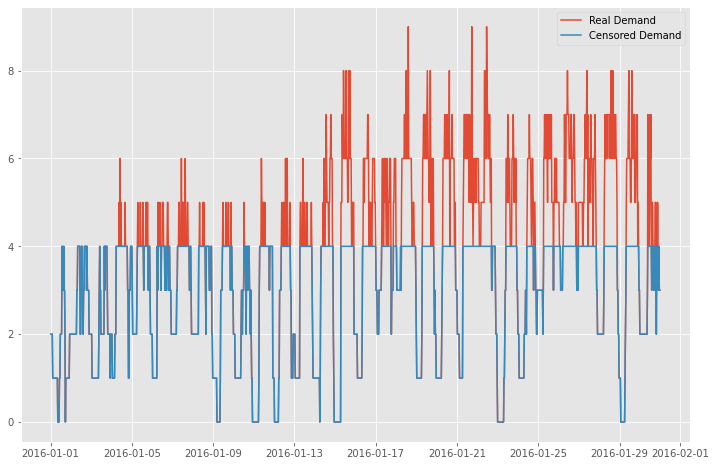

In [9]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4

plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [196]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        return out

In [197]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

X_train = df_sample.reset_index(drop=True).iloc[:input_dim]
y_train = df_sample.reset_index(drop=True).iloc[input_dim:input_dim+output_dim]

model = AR(input_dim, output_dim)

In [198]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    return loss.data.item()



In [216]:
def poissonLoss(predicted, observed):
    """Custom loss function for Poisson model."""
    loss=torch.mean(predicted-observed*torch.log(predicted))
    return loss

    
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))


def censored_poisson_negative_log_likelihood(y_predict, y, tau):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    if y_predict < tau: 
        d = 1
    else: d = 0

    return d*(torch.exp(y_predict)*torch.exp(-y_predict)) + (1-d)*(-torch.sum(y*y_predict - torch.exp(y_predict)))

def nb_loss(z, mean, alpha):
    r = 1 / alpha
    ma = mean * alpha
    pdf = torch.lgamma(z + r)
    pdf -= torch.lgamma(z + 1)
    pdf -= torch.lgamma(r)
    pdf += r * torch.log(1 / (1 + ma))
    pdf += z * torch.log(ma / (1 + ma))
    pdf = torch.exp(pdf)

    loss = torch.log(pdf)
    loss = torch.mean(loss)
    loss = - loss

    return loss



Epoch: 0 Loss: -32.791534423828125
Epoch: 1 Loss: 34.60402297973633
Epoch: 2 Loss: -28.418785095214844
Epoch: 3 Loss: -16.443674087524414
Epoch: 4 Loss: -2.9250099658966064
Epoch: 5 Loss: -10.396195411682129
Epoch: 6 Loss: -14.233602523803711
Epoch: 7 Loss: -14.7560453414917
Epoch: 8 Loss: -18.532920837402344
Epoch: 9 Loss: -25.019424438476562
Epoch: 10 Loss: -28.831375122070312
Epoch: 11 Loss: -26.60848617553711
Epoch: 12 Loss: -21.864944458007812
Epoch: 13 Loss: -21.071109771728516
Epoch: 14 Loss: -25.954072952270508
Epoch: 15 Loss: -31.293243408203125
Epoch: 16 Loss: -32.15513229370117
Epoch: 17 Loss: -29.132625579833984
Epoch: 18 Loss: -25.98824691772461
Epoch: 19 Loss: -25.51418685913086
Epoch: 20 Loss: -27.820446014404297
Epoch: 21 Loss: -30.900575637817383
Epoch: 22 Loss: -32.36330032348633
Epoch: 23 Loss: -31.513368606567383
Epoch: 24 Loss: -29.985929489135742
Epoch: 25 Loss: -29.62544059753418
Epoch: 26 Loss: -30.478988647460938
Epoch: 27 Loss: -31.442907333374023
Epoch: 28 Lo

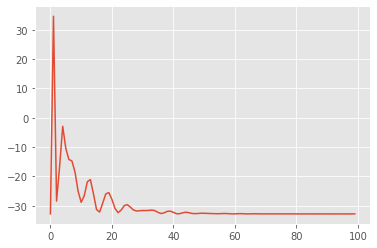

In [217]:
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = poisson_negative_log_likelihood
losses = []
for epoch in range(epochs):
    x = torch.tensor(X_train.Sessions.values, dtype=torch.float32).view(1, -1)
    y = torch.tensor(y_train.Sessions.values, dtype=torch.float32).view(1, -1)
    loss = train_batch(model, x, y, optimizer, loss_fn)
    losses.append(loss)
    print(f'Epoch: {epoch} Loss: {loss}')
plt.plot(losses)


In [218]:
y_predict = model.forward(x)
y_predict = y_predict.detach().numpy().reshape(-1)

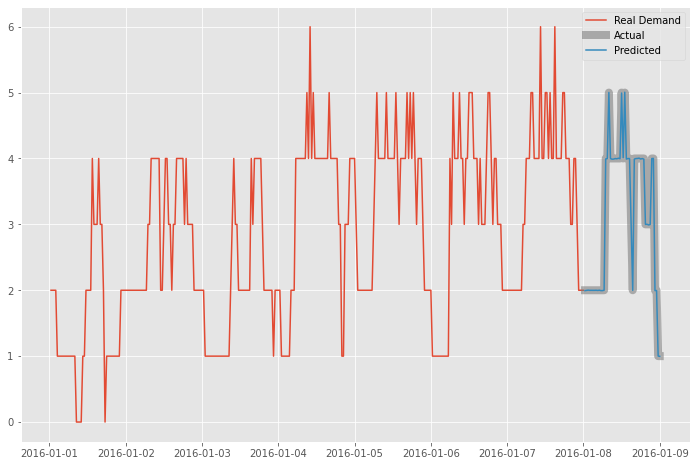

In [220]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(X_train.Period, X_train.Sessions.values, label='Real Demand')
plt.plot(y_train.Period, y_train.Sessions.values, label='Actual', alpha = 0.6, color = 'grey', linewidth = 8)
plt.plot(y_train.Period, np.exp(y_predict), label='Predicted')
plt.legend()

Alternative model

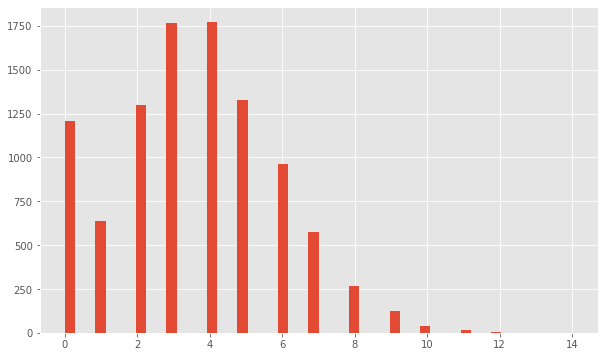

In [194]:
# true distribution parameters
import pytorch_lightning as pl

p_d1 = 0.9
p_lambda = 4

n = 10000
rand_gen = np.random.default_rng(seed=0)

poisson_samples = rand_gen.poisson(lam=p_lambda, size=(n, 1))
mix_samples = rand_gen.binomial(n=1, p=p_d1, size=(n, 1))
rand_samples = mix_samples * poisson_samples

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(rand_samples, bins=50)
plt.show()

In [145]:
class ZIPModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=1e-3,
        init_mix_parameter: float = 0.9,
        init_poisson_lambda: float = 4.0,
    ):
    
        super().__init__()
        self.mixture_prob = torch.nn.Parameter(torch.tensor([init_mix_parameter]))
        self.poisson_lambda = torch.nn.Parameter(torch.tensor([init_poisson_lambda]))

        self.train_log_error = []
        self.val_log_error = []
        self.mixture_prob_log = []
        self.poisson_lambda_log = []
        self.learning_rate = learning_rate

    def forward(self):
        # ensure correct domain for params
        mixture_prob_norm = torch.sigmoid(self.mixture_prob)
        poisson_lambda_norm = torch.nn.functional.softplus(self.poisson_lambda)
        poisson_lambda_norm = torch.concat(
            (torch.tensor([0.0]), poisson_lambda_norm)
        )  # maintains grad

        mix = torch.distributions.Categorical(
            torch.concat((mixture_prob_norm, 1 - mixture_prob_norm))
        )
        poissons = torch.distributions.Poisson(poisson_lambda_norm)

        mixture_dist = torch.distributions.MixtureSameFamily(mix, poissons)
        return mixture_dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.learning_rate,
        )
        
        return optimizer

    def training_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        self.poisson_lambda_log.append(
            torch.nn.functional.softplus(self.poisson_lambda).detach().numpy()
        )
        self.mixture_prob_log.append(torch.sigmoid(self.mixture_prob).detach().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        y = batch[0]

        mixture_dist = self.forward()

        negloglik = -mixture_dist.log_prob(y)
        loss = torch.mean(negloglik)

        self.train_log_error.append(loss.detach().numpy())
        return loss


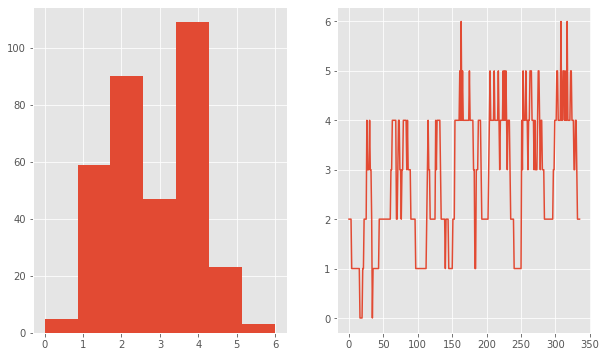

In [146]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].hist(X_train, bins=7)
ax[1].plot(X_train)
plt.show()

In [182]:
torch.manual_seed(4)
model = ZIPModel(learning_rate=1e-0, init_mix_parameter=0.0, init_poisson_lambda=4.0)

(array([ 6., 20., 24.,  0., 14., 19.,  0., 11.,  2.,  4.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

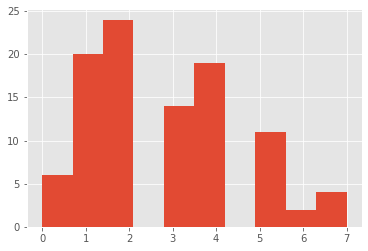

In [183]:
plt.hist(output_dist.sample((100, 1)).numpy())

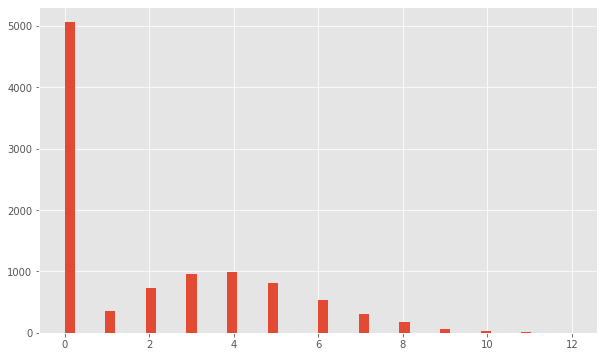

In [184]:
output_dist = model()
output_samples = output_dist.sample((n, 1)).numpy().squeeze()

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(output_samples, bins=50)
plt.show()

In [185]:
from torch.utils.data import TensorDataset, DataLoader

rand_samples_t = torch.Tensor(X_train)
dataset_train = TensorDataset(rand_samples_t)
dataloader_train = DataLoader(dataset_train, batch_size=len(rand_samples))

# test loading a batch
rand_samples_batch = next(iter(dataloader_train))
rand_samples_batch[0].shape

ValueError: could not determine the shape of object type 'DataFrame'

In [186]:
trainer = pl.Trainer(
    max_epochs=500,
)
trainer.fit(model, dataloader_train)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name | Type | Params
------------------------------
------------------------------
2         Trainable params
0         Non-trainable params
2         Total params
0.000     Total estimated model params size (MB)
/opt/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/lib/

Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 119.53it/s, loss=1.75, v_num=6]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 78.40it/s, loss=1.75, v_num=6] 


/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_2694/492566248.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


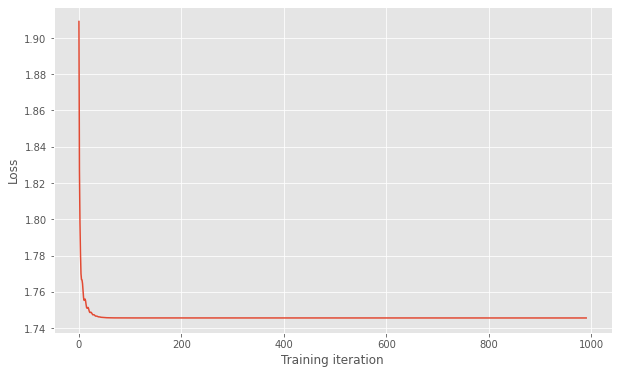

In [187]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(moving_average(np.array(model.train_log_error)))
ax.set_ylabel("Loss")
ax.set_xlabel("Training iteration")
fig.show()

/var/folders/zw/yys6vm7506q010fwbsz_3djr0000gn/T/ipykernel_2694/2646926644.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


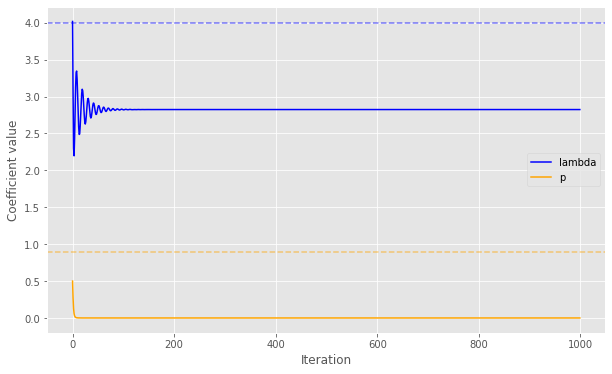

In [188]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(model.poisson_lambda_log, color="b", label="lambda")
ax.plot(model.mixture_prob_log, color="orange", label="p")
ax.axhline(y=p_lambda, linestyle="--", color="b", alpha=0.5)
ax.axhline(y=p_d1, linestyle="--", color="orange", alpha=0.5)
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Coefficient value")
fig.show()

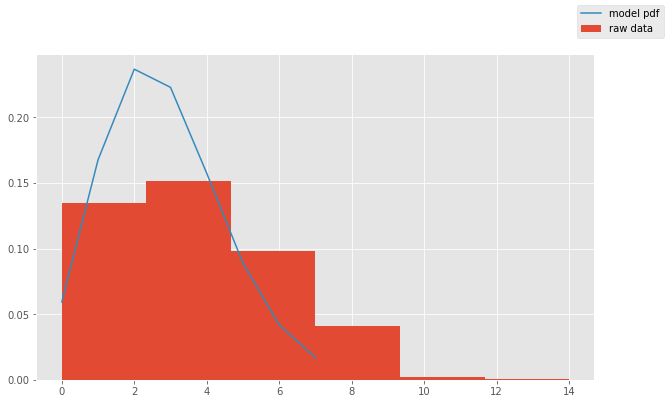

In [189]:
output_dist = model()
x = torch.arange(0, 8)
y = torch.exp(output_dist.log_prob(x))

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    rand_samples,
    bins = 6, #bins=rand_samples.max() - rand_samples.min(),
    density=True,
    label="raw data",
)
ax.plot(x.detach().numpy(), y.detach().numpy(), label="model pdf")
fig.legend()
plt.show()

14